<h1><b>Méthode : Ensemble Kalman Filter (EnKF)</b></h1>

Ce notebook présente l'utilisation du fichier `kalmanWoFost.py` pour assimiler des données

In [7]:
from kalmanWoFost import KalmanWofostDA
import numpy as np 
from pcse.models import Wofost72_WLP_FD
import datetime as dt
import pandas as pd

from dataloader import Dataloader
import os

from pcse.base import ParameterProvider
from utils import *

## 1 - Paramètres de WOFOST

Dans cette partie, on va charger les paramètres qui serviront à modéliser le champ avec Wofost.
Dans cet exemple, on va essayer de simuler le champ de notre client


In [8]:
dataloader = Dataloader("data")

# ===  1 - Crop Data ===
dataloader.printCropNames()
dataloader.printCropVarietes('potato')

cropd = dataloader.getCropData('potato', 'Innovator')
# Alternativement, vous pouvez charger un fichier
# cropd = dataloader.readCropData("POT701.CAB")



# === 2 - Paramètres du sol ===
# Chargé depuis un fichier
# 1. **EC1-Coarse**
# 2. **EC2-Medium**
# 3. **EC3-Medium Fine**
# 4. **EC4-Fine**
# 5. **EC5-Very Fine**
# 6. **EC6-Fine and Permeable (Peat)**
soild = dataloader.readSoilData("ec3.soil")

# === 3 - Paramètres du site ===
# Il s'agit des paramètres du site, indépendamment de l'espèce
#        - WAV       Initial amount of water in total soil profile [cm] <- OBLIGATOIRE
#        - IFUNRN    Indicates whether non-infiltrating fraction of rain is a function of storm size (1)
#                    or not (0). Default 0
#        - NOTINF    Maximum fraction of rain not-infiltrating into the soil [0-1], default 0.
#        - SSMAX     Maximum depth of water that can be stored on the soil surface [cm]
#        - SSI       Initial depth of water stored on the surface [cm]
#        - SMLIM     Initial maximum moisture content in initial rooting depth zone [0-1], default 0.4
sited = dataloader.getSiteData(WAV=10)


# === 4 - Agromanagement ===
agrod = dataloader.readAgromanagementData('osiris_rampe_cleaned.agro')

# === 5 - Météo ===
weatherd = dataloader.getWeatherData(lat=49.5652319502033, lon=2.4757816885380457)

# On rassemble tout
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

Voici la liste des espèces disponibles :
['barley', 'cassava', 'chickpea', 'cotton', 'cowpea', 'fababean', 'groundnut', 'maize', 'millet', 'mungbean', 'pigeonpea', 'potato', 'rapeseed', 'rice', 'sorghum', 'soybean', 'sugarbeet', 'sugarcane', 'sunflower', 'sweetpotato', 'tobacco', 'wheat', 'seed_onion']
Voici la liste des variétés disponibles pour : potato
['Potato_701', 'Potato_702', 'Potato_703', 'Potato_704', 'Innovator', 'Fontane', 'Markies', 'Premiere', 'Festien']


In [9]:

cropd = dataloader.getCropData('potato', 'Innovator')
print(cropd)

YAMLCropDataProvider - current active crop 'potato' with variety 'Innovator'
Available crop parameters:
 {'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11], 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9], 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9], 'TBASEM': 3.0, 'TEFFMX': 18.0, 'TSUMEM': 255, 'IDSL': 0, 'DLO': -99.0, 'DLC': -99.0, 'TSUM1': 187, 'TSUM2': 2100, 'DTSMTB': [0.0, 0.0, 2.0, 0.0, 13.0, 11.0, 30.0, 28.0], 'DVSI': 0.0, 'DVSEND': 2.0, 'VERNBASE': 14.0, 'VERNSAT': 70.0, 'VERNDVS': 0.3, 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0], 'TDWI': 75.0, 'RGRLAI': 0.017, 'SLATB': [0.0, 0.0017, 1.0, 0.0024, 2.0, 0.0024], 'SPA': 0.0, 'SSATB': [0.0, 0.0, 2.0, 0.0], 'SPAN': 35.0, 'TBASE': 2.0, 'KDIFTB': [0.0, 1.0, 2.0, 1.0], 'EFFTB': [0.0, 0.49, 40.0, 0.49], 'AMAXTB': [0.0, 33.0, 2.0, 33.0], 'REFCO2L': 400, 'TMPFTB': [0.0, 0.01, 3.0, 0.01, 10.0, 0.75, 15.0, 1.0, 24.0, 1.0, 29.

## 2 - Simulation

On peut maintenant prédire avec WoFOST

In [10]:
wofost_noDA = getWofost_WaterLimited(parameters, weatherd, agrod)
wofost_noDA.run_till_terminate()
df_wofost_noDA = pd.DataFrame(wofost_noDA.get_output())
df_wofost_noDA = df_wofost_noDA.set_index("day")
df_wofost_noDA.tail()
#plotWofostDF(df_wofost_noDA)

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.210778,22.853864
2022-10-03,1.989233,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.233504,23.990159
2022-10-04,1.993524,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.231734,23.901671
2022-10-05,1.998490,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.230315,23.830729
2022-10-06,2.000000,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.229977,23.813845


# 3 - Observations

On va réaliser des observations pour améliorer notre simulation : c'est la data assimilation.

Dans cette partie, on va utiliser les observations du client

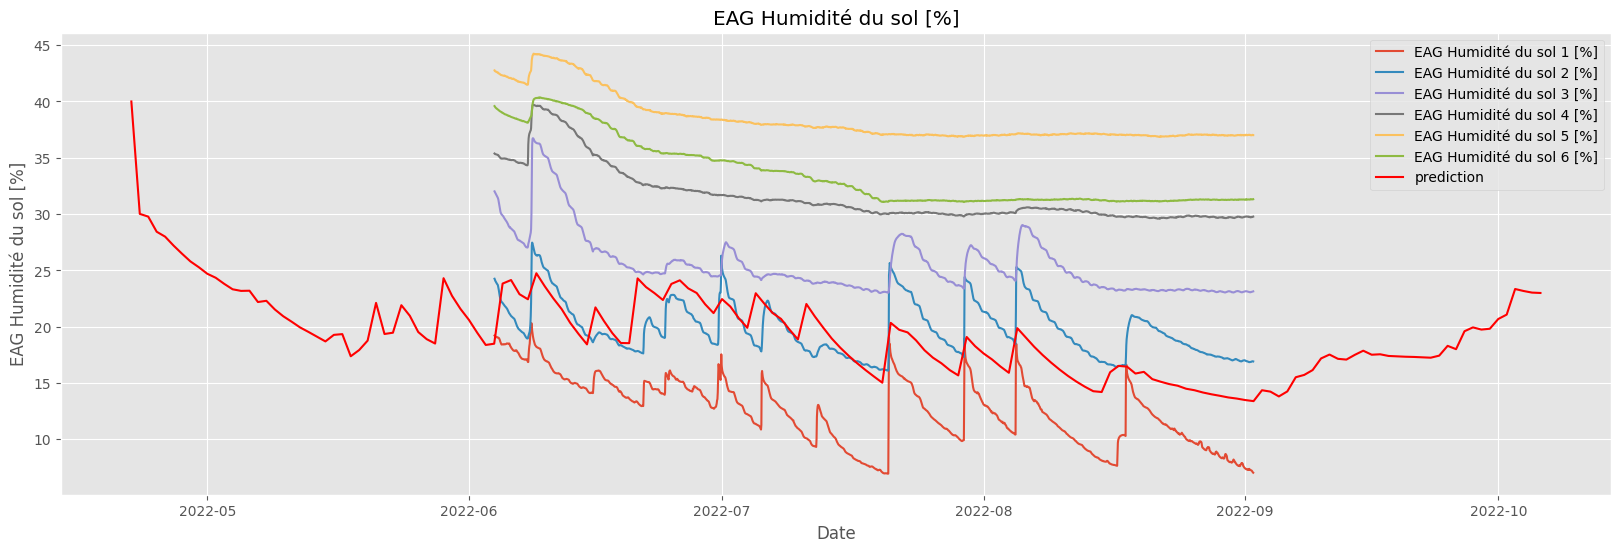

In [12]:
import matplotlib.pyplot as plt

df_obs = dataloader.readOsirisData('Sonde Rampe 1.csv')
df_obs = df_obs[df_obs['Date/heure'] < pd.Timestamp("2022-09-02")]
df_obs = df_obs[df_obs['Date/heure'] > pd.Timestamp("2022-06-04")]

plt.figure(figsize=(20, 6))

for i in range(1, 7):
    column_name = f'EAG Humidité du sol {i} [%]'
    plt.plot(df_obs['Date/heure'],df_obs[column_name], label=column_name)
    
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM']*100, label='prediction', color="r")

plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()

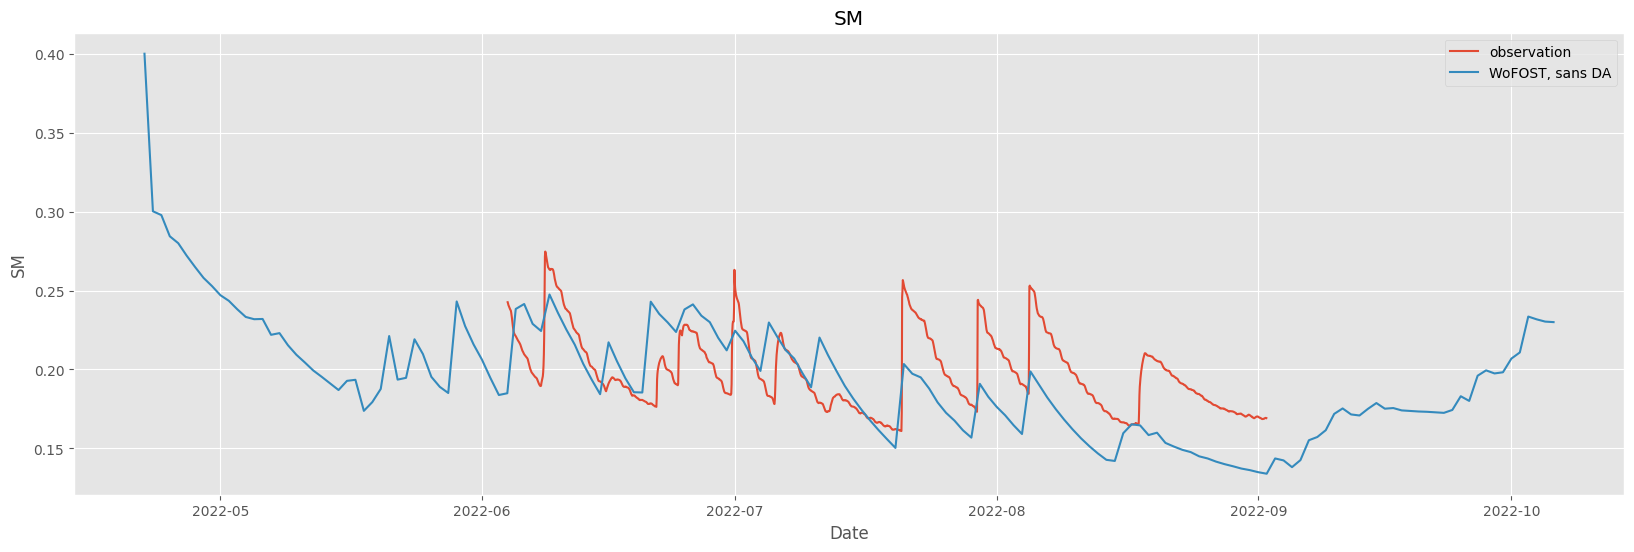

In [94]:
plt.figure(figsize=(20, 6))

plt.plot(df_obs['Date/heure'], df_obs['SM'], label = 'observation')
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM'], label='WoFOST, sans DA')
plt.title("SM")
plt.xlabel('Date')
plt.legend()
plt.ylabel("SM")
plt.grid(True)
plt.show()

Pour mesurer l'effet de la fréquence des mesures, on va échantilloner les données à notre disposition

In [112]:
NB_DAYS_DELTA = 4
dates_of_observation, observed_sm = dataloader.getOsirisSM(filename = 'Sonde Rampe 1.csv', timedelta = pd.Timedelta(NB_DAYS_DELTA, "d"), error = 0.0, begin = pd.Timestamp("2022-06-04"), end = pd.Timestamp("2022-09-02"))

observed_sm = np.array(observed_sm)
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value

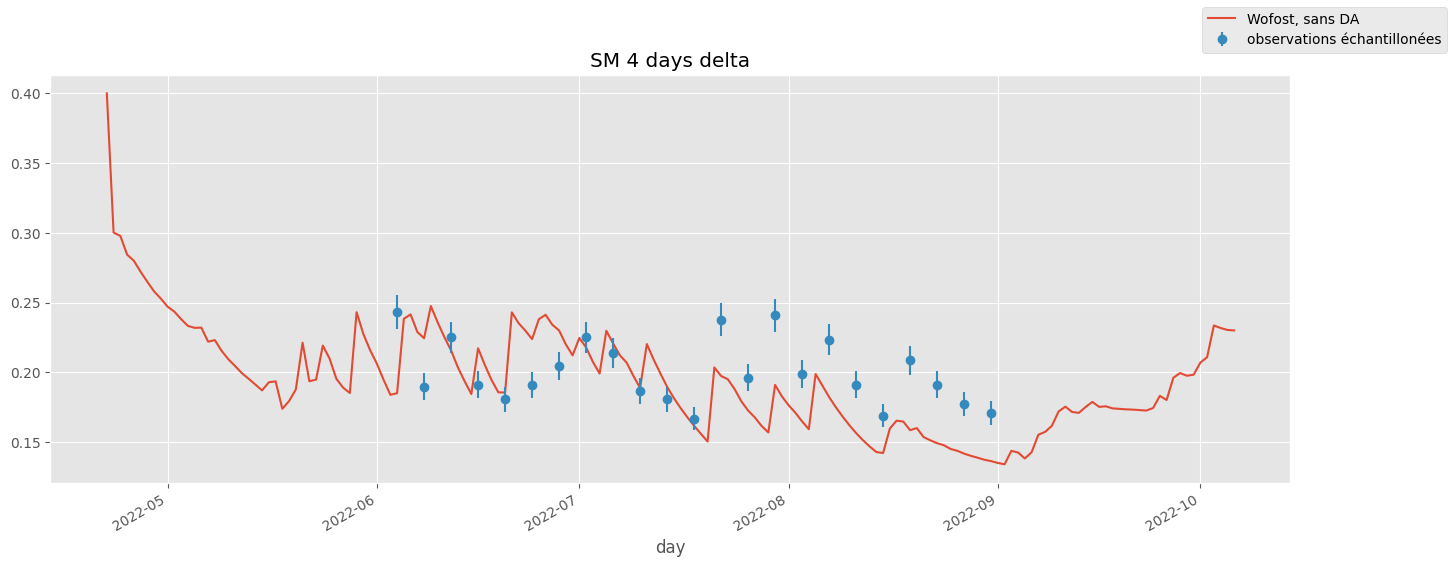

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_wofost_noDA["SM"].plot(ax=axes, label="Wofost, sans DA")
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
fig.legend()

On doit maintenant tout rassembler :

In [97]:
observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]

## 4 - EnKF

On peut maintenant utiliser l'EnKF

Il faut d'abord spécifier les paramètres sur lesquels on a un doute.

In [98]:
ensemble_size = 50
np.random.seed(10000)

print("TDWI", parameters['TDWI'])
print("WAV", parameters["WAV"])
print("SPAN", parameters["SPAN"])
print("SMFCF", parameters["SMFCF"])

TDWI 75.0
WAV 10.0
SPAN 35.0
SMFCF 0.3



On créé ensuite une zone de recherche autour des paramètres que l'on cherche à assimiler.

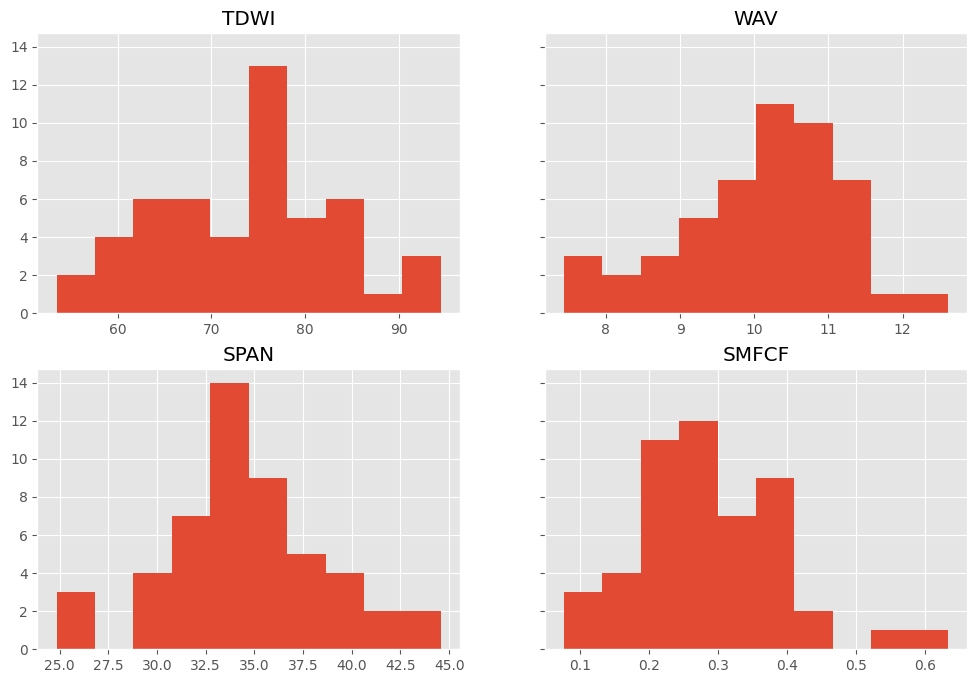

In [99]:
ensemble_size = 50

override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.maximum(0.5, np.random.normal(parameters['TDWI'], 10, (ensemble_size)))
override_parameters["WAV"] = np.maximum(0.5, np.random.normal(parameters['WAV'], 1.0, (ensemble_size)))
# parameters
override_parameters["SPAN"] = np.maximum(0.5, np.random.normal(parameters['SPAN'], 4 ,(ensemble_size)))
override_parameters["SMFCF"] = np.maximum(0.01, np.random.normal(parameters['SMFCF'], 0.1 ,(ensemble_size)))


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

Finalement, on peut créer et faire tourner notre modèle:

On peut récupérer le résultat de notre simulation

In [100]:
kwf = KalmanWofostDA(parameters=parameters, weather=weatherd, agromanagement=agrod, ensemble_size=ensemble_size, override_parameters=override_parameters)
kwf.batchAssimilate(observations_for_DA)
df_enkf_DA = kwf.getResultsWithDA()
df_enkf_NODA = kwf.getResultsNoDA()

[KalmanWoFoStDA] Assimilating data for {'SM': (0.24350000000000002, 0.012175000000000002)} on day 2022-06-04 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2018, 0.010090000000000002)} on day 2022-06-14 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1907, 0.009535000000000002)} on day 2022-06-24 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.19399999999999998, 0.0097)} on day 2022-07-04 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1805, 0.009025)} on day 2022-07-14 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.2198, 0.01099)} on day 2022-07-24 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.19879999999999998, 0.00994)} on day 2022-08-03 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.1787, 0.008935)} on day 2022-08-13 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.191, 0.009550000000000001)} on day 2022-08-23 00:00:00 
[KalmanWoFoStDA] Assimilating data for {'SM': (0.16920000000000002, 0.00

In [101]:
df_enkf_DA.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-08-29,1.754505,0.218572,15244.275904,12105.977069,1636.527199,1501.771635,1285.984125,0.044873,50.0,0.169269,21.058229
2022-08-30,1.763114,0.187833,15247.354508,12109.040559,1636.527199,1501.786751,1285.984125,0.033119,50.0,0.167315,20.960523
2022-08-31,1.771819,0.161064,15248.866532,12110.545419,1636.527199,1501.793914,1285.984125,0.026301,50.0,0.165985,20.894019
2022-09-01,1.780590,0.137620,15249.416100,12111.092478,1636.527199,1501.796422,1285.984125,0.022241,50.0,0.164407,20.815115
2022-09-02,1.789938,0.116250,15249.416100,12111.092478,1636.527199,1501.796422,1285.984125,0.014586,50.0,0.163216,20.755566


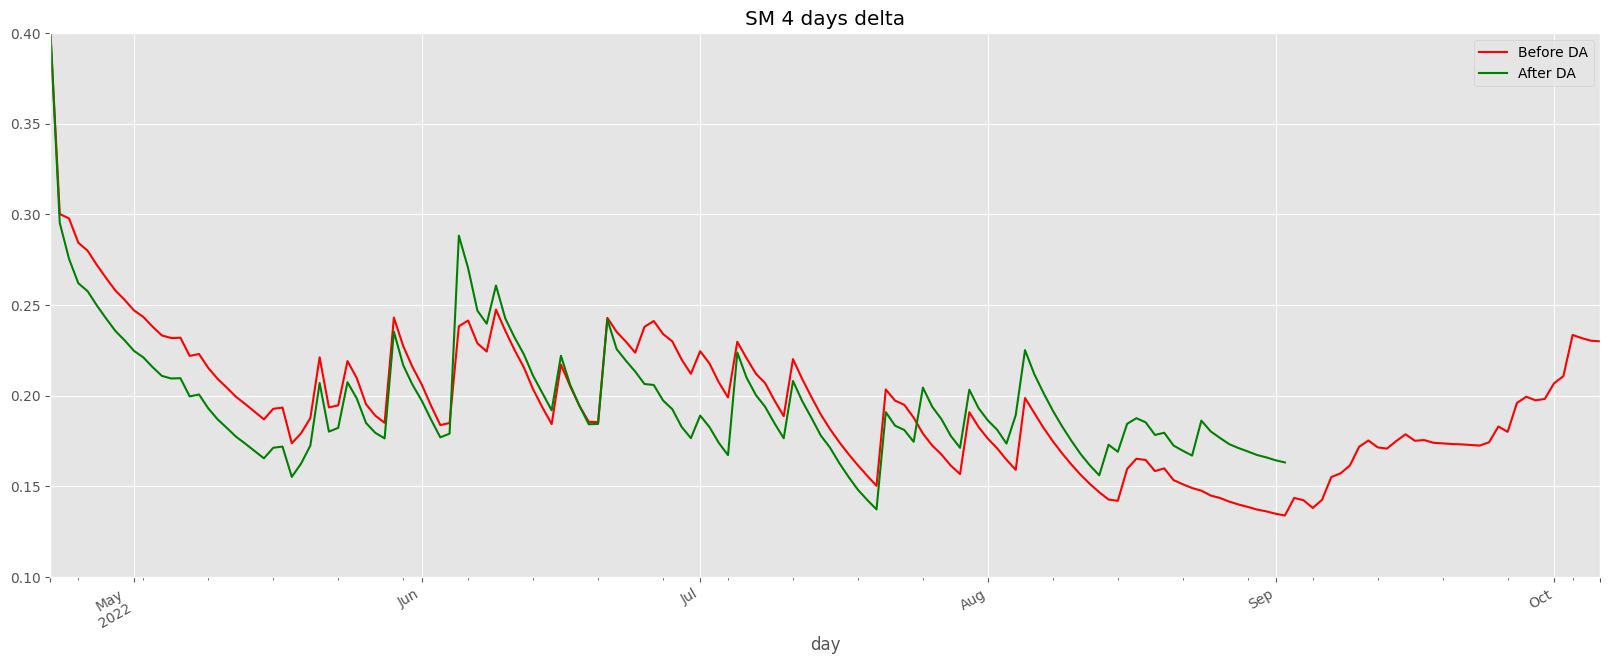

In [119]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

# axes.plot(df_obs['Date/heure'], df_obs["SM"], label="All Observations", color='b')

df_enkf_NODA['SM'].plot(ax=axes, label="Before DA", color='r')
df_enkf_DA['SM'].plot(ax=axes, label="After DA", color='g')

# axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='RED', label='Observations (sampled)')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
axes.set_ylim([0.1, 0.4])

axes.legend()

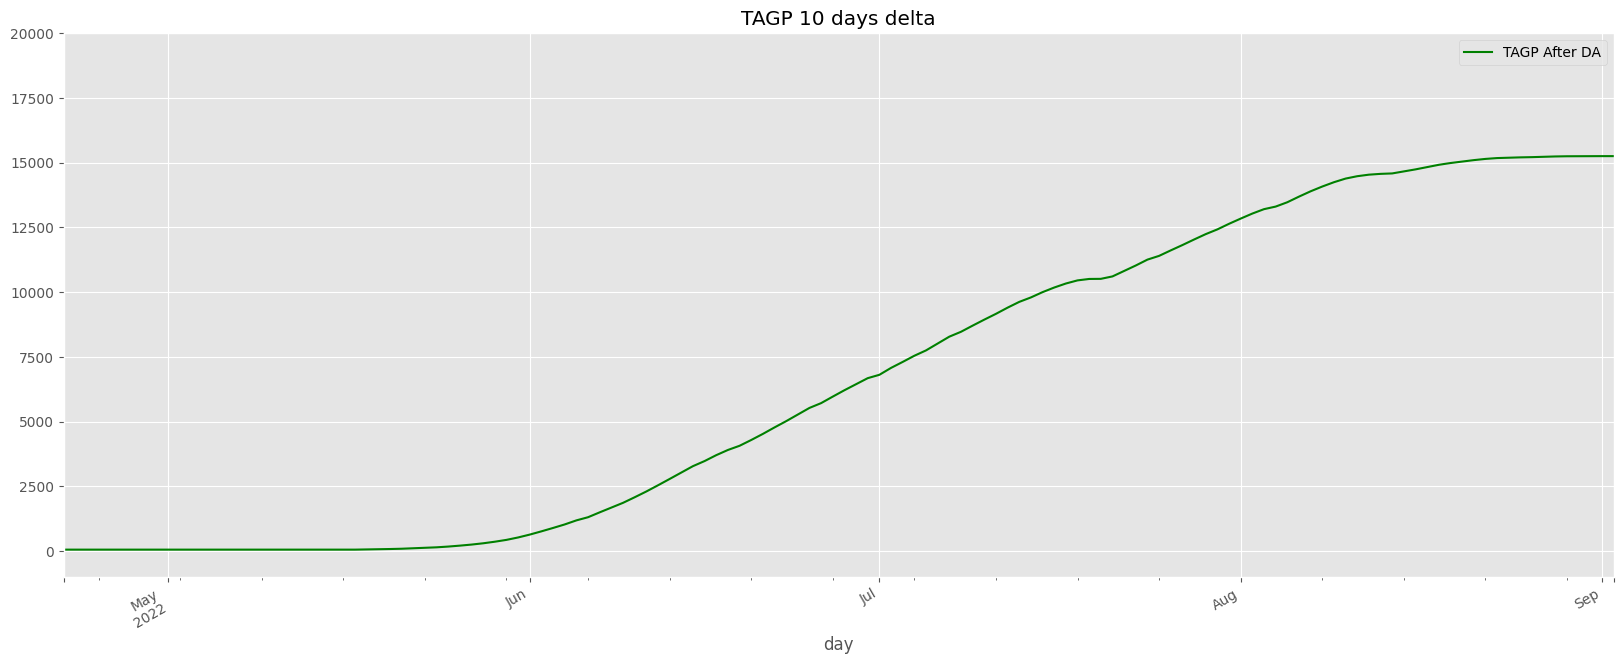

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,8), sharex=True)

df_enkf_DA['TAGP'].plot(ax=axes, label="TAGP After DA", color='g')

#axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="x", alpha=0.8, color='gray')
axes.set_title("TAGP "+str(NB_DAYS_DELTA)+" days delta")
axes.set_ylim([-1000, 20000])
fig.autofmt_xdate()

axes.legend()

In [104]:
df_enkf_DA.index

DatetimeIndex(['2022-04-22', '2022-04-23', '2022-04-24', '2022-04-25',
               '2022-04-26', '2022-04-27', '2022-04-28', '2022-04-29',
               '2022-04-30', '2022-05-01',
               ...
               '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-27',
               '2022-08-28', '2022-08-29', '2022-08-30', '2022-08-31',
               '2022-09-01', '2022-09-02'],
              dtype='datetime64[ns]', name='day', length=134, freq=None)

In [105]:
df_obs_undersample = df_obs[df_obs['Date/heure'].dt.hour == 0]
minDay = max((df_obs_undersample['Date/heure'].min()), df_enkf_DA.index.min())
maxDay = min(df_obs_undersample['Date/heure'].max(), df_enkf_DA.index.max())

print(minDay, maxDay)


2022-06-05 00:00:00 2022-09-01 00:00:00


<AxesSubplot: xlabel='day'>

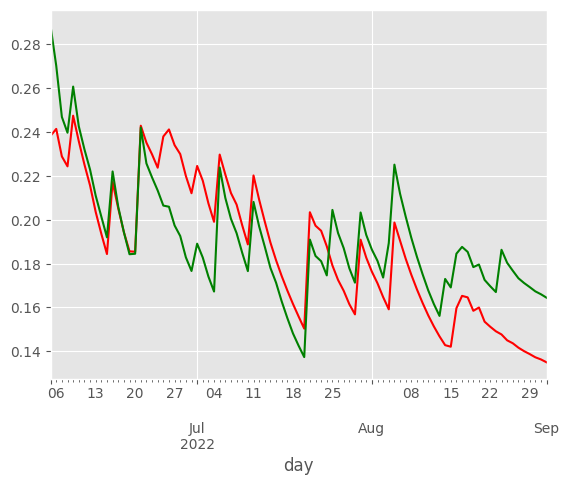

In [123]:
SM_obs = df_obs_undersample.loc[(df_obs_undersample.index >= minDay) & (df_obs_undersample.index <= maxDay), 'SM'].to_numpy()
SM_DA = df_enkf_DA.loc[(df_enkf_DA.index >= minDay) & (df_enkf_DA.index <= maxDay), 'SM'].to_numpy()
SM_noDA = df_enkf_NODA.loc[minDay:maxDay, 'SM'].to_numpy()

In [124]:
# from sklearn.metrics import root_mean_squared_error

# root_mean_squared_error(SM_obs, SM_DA)
print(np.sqrt(np.mean((SM_obs-SM_DA)**2)))
print(np.sqrt(np.mean((SM_obs-SM_noDA)**2)))


0.025831020954390667
0.029770330842744726


| 1d | 0.01847633509091331 |

| 2d | 0.0213640528341585

| 3d | 0.021485466365227544 |

| 4d | 0.023846332646046277 |

| 5d | 0.02395909798916903 |

| 6d | 0.02313019439906722 |

| 7d | 0.02165653528296338 |

| 8d | 0.022373623101980617 |

| 10d | 0.025831058391581837 |

| 14d | 0.025129247525136345 |

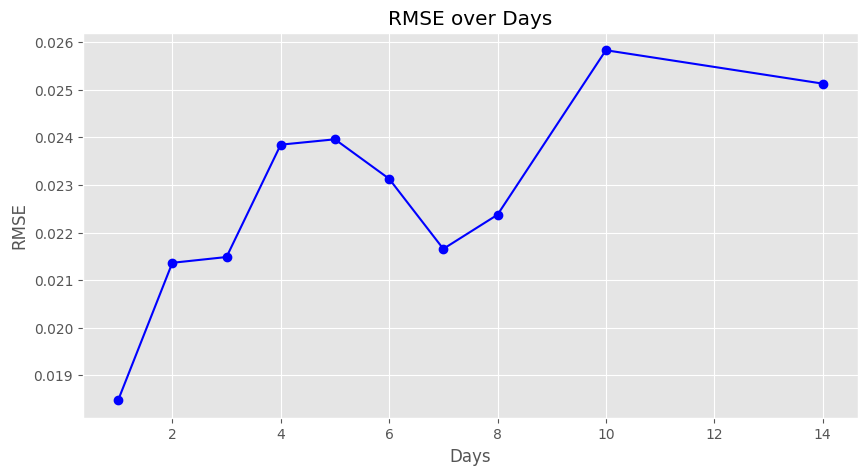

In [109]:
import matplotlib.pyplot as plt

# Data
days = [1, 2, 3, 4, 5, 6, 7, 8, 10, 14]
rmse = [0.01847633509091331, 0.0213640528341585, 0.021485466365227544, 0.023846332646046277, 
        0.02395909798916903, 0.02313019439906722, 0.02165653528296338, 0.022373623101980617, 0.025831058391581837, 
        0.025129247525136345]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(days, rmse, marker='o', linestyle='-', color='b')

# Labels and title
plt.xlabel('Days')
plt.ylabel('RMSE')
plt.title('RMSE over Days')

# Show plot
plt.grid(True)
plt.show()


Témoin: 0.14991962095173939


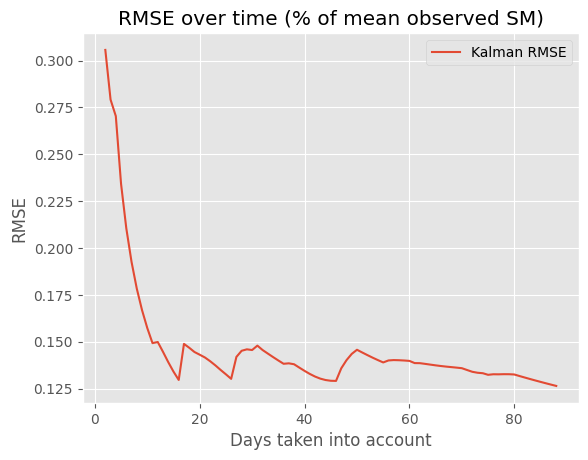

In [127]:
rsme = {i:np.sqrt(np.mean((SM_obs[1:i]-SM_DA[1:i])**2)) for i in range(len(SM_DA))}
plt.plot(list(rsme.keys()),list(rsme.values())/np.mean(SM_obs), label="Kalman RMSE")
print("Témoin: {}".format(np.sqrt(np.mean((SM_obs-SM_noDA)**2))/np.mean(SM_obs)))
plt.title("RMSE over time (% of mean observed SM)")
plt.xlabel("Days taken into account")
plt.ylabel("RMSE")
plt.legend()

On peut tirer plusieurs conclusion de ce dernier graphique. Le RMSE est initalement plutôt petit: le KF est assez efficace. Après plusieurs itérations, il se stagne vers 0.11 d'écart, ce qui correspond à 11% d'écarts sur la période.
    <style>
        table {
            width: 100%;
        }
    </style>
| Pas des jours | Erreur RMSE (%) |
|---------------|-------|
|1|8,5|
| 2             | 10,5  |
| 4             | 11,7  |
| 8             | 11,8  |
| 10            | 12,8  | 
| témoin        | 14,9  |
